# Trabajo Práctico 2: Análisis con Random Forest - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba


## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import aplicar_one_hot_encoding

In [4]:
from funciones_auxiliares import graficar_auc_roc
from funciones_auxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [5]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [6]:
X, y = dividir_dataset(df)
X_train_test, X_holdout, y_train_test, y_holdout = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

## Búsqueda de hiperparámetros
Definimos los mejores hiperparámetros, que son 'criterio', 'estimadores' y 'profundidad' mediante la siguiente función de búsqueda, que utiliza Stratified K-folds cross validation para comparar cada combinación y así obtener la mejor. Nos quedamos con la combinación cuya media de los k-folds(5) tenga la mejor métrica. La métrica de comparación utilizada es AUC-ROC.

In [7]:
def definir_mejores_hiperparametros(X, y, modelo):
    params = {'criterion': ['gini','entropy'], 'n_estimators':[100,200,300,400,500],'max_depth': [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
    grid_search = GridSearchCV(modelo, params, scoring='roc_auc', n_jobs=-1, cv=5).fit(X, y)    
    return grid_search.best_params_  


## Entrenamiento y predicción con el dataset original
Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [8]:
mejor_combinacion = definir_mejores_hiperparametros(X_train_test, y_train_test, RandomForestClassifier())

Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [9]:
mejor_profundidad = mejor_combinacion['max_depth']
mejor_estimadores = mejor_combinacion['n_estimators']
mejor_criterio = mejor_combinacion['criterion']
print(f'Mejor profundidad máxima: {mejor_profundidad}')
print(f'Mejor n° de estimadores: {mejor_estimadores}')
print(f'Mejor criterio: {mejor_criterio}')


Mejor profundidad máxima: 15
Mejor n° de estimadores: 500
Mejor criterio: entropy


Entrenamos un RandomForest con esa combinación de hiperparámetros.

In [10]:
random_forest = RandomForestClassifier(n_jobs = -1,max_depth = mejor_profundidad, n_estimators = mejor_estimadores, criterion = mejor_criterio)
random_forest.fit(X_train_test, y_train_test)

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=500,
                       n_jobs=-1)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

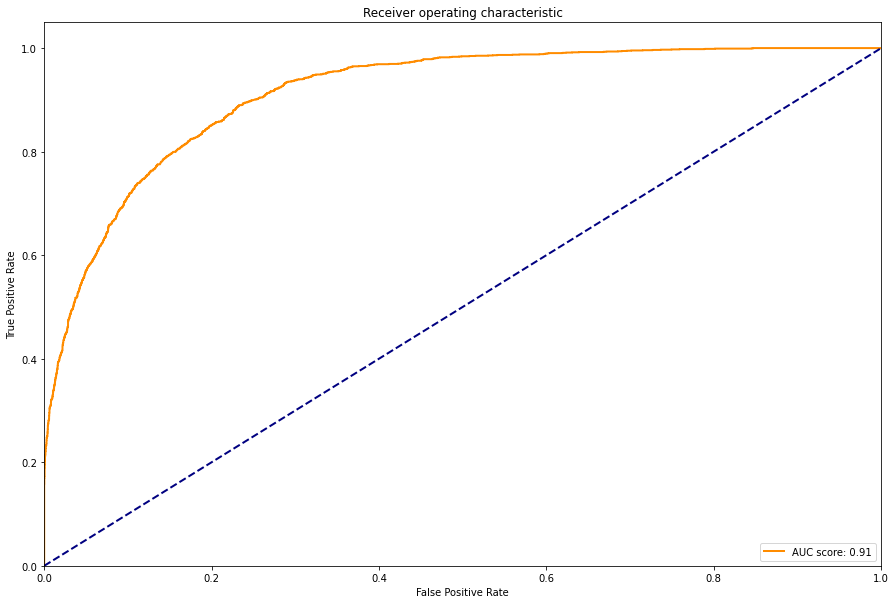

El valor de la metrica AUC-ROC para este modelo es: 0.9128777210609208


In [11]:
y_pred = random_forest.predict(X_holdout)
y_pred_proba = random_forest.predict_proba(X_holdout)[:, 1]
graficar_auc_roc(y_holdout, y_pred_proba)

Podemos observar que nos dio un valor muy elevado (0.92) lo que tiene sentido ya que se trata de un ensamble.

Mostramos el classification report:

In [12]:
print(classification_report(y_holdout, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))


                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.875     0.949     0.911      6181
   Tiene Alto Valor Adquisitivo      0.781     0.574     0.662      1960

                       accuracy                          0.859      8141
                      macro avg      0.828     0.761     0.786      8141
                   weighted avg      0.853     0.859     0.851      8141



Por último, mostramos la matriz de confusión correspondiente:

In [13]:
from funciones_auxiliares import graficar_matriz_confusion

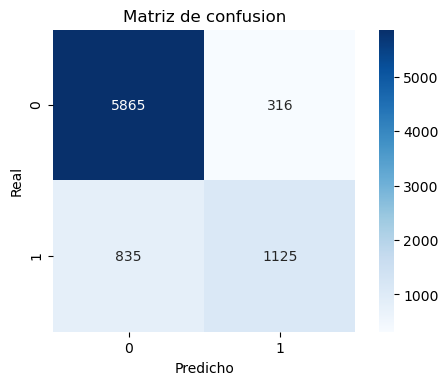

In [14]:
graficar_matriz_confusion(y_holdout, y_pred)

Podemos ver que Random Forest es un muy buen clasificador para los contribuyentes con bajo valor adquisitivo. Además, es relativamente bueno para aquellas instancias con alto valor adquisitivo, ya que tiene un valor alto de precision.

Se observa una tendencia a predecir instancias de bajo valor adquisitivo. Esto se hace evidente viendo que aproximadamente un 42% de las instancias de alto valor fueron predichas incorrectamente por el modelo. Sin embargo, el valor de precision de esas instancias es bastante alto, como se mencionó antes.

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [15]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [16]:
X_exp = expandir_dataset(X)
X_exp_train_test, X_exp_holdout, y_exp_train_test, y_exp_holdout = train_test_split(X_exp, y, test_size=0.25, random_state=0, stratify=y)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [17]:
mejor_combinacion = definir_mejores_hiperparametros(X_exp_train_test, y_exp_train_test, RandomForestClassifier())

A continuación, vemos la mejor combinación de hiperparámetros obtenida.

In [18]:
mejor_profundidad = mejor_combinacion['max_depth']
mejor_estimadores = mejor_combinacion['n_estimators']
mejor_criterio = mejor_combinacion['criterion']
print(f'Mejor profundidad máxima: {mejor_profundidad}')
print(f'Mejor n° de estimadores: {mejor_estimadores}')
print(f'Mejor criterio: {mejor_criterio}')


Mejor profundidad máxima: 17
Mejor n° de estimadores: 500
Mejor criterio: entropy


Entrenamos un RandomForest con esa combinación de hiperparámetros.

In [19]:
random_forest_expandido = RandomForestClassifier(n_jobs = -1,max_depth = mejor_profundidad, n_estimators = mejor_estimadores, criterion = mejor_criterio)
random_forest_expandido.fit(X_exp_train_test, y_exp_train_test)

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=500,
                       n_jobs=-1)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

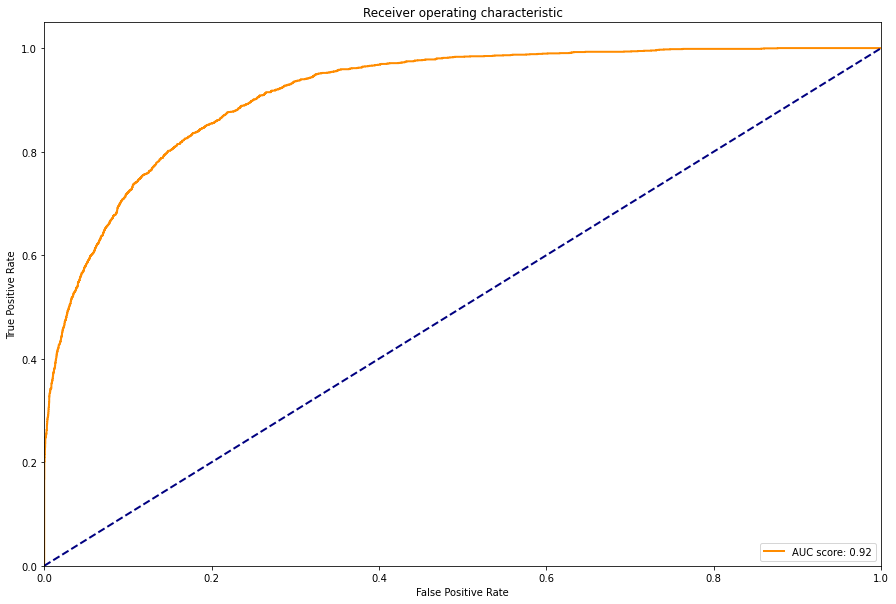

El valor de la metrica AUC-ROC para este modelo es: 0.9152052950285436


In [20]:
y_pred = random_forest_expandido.predict(X_exp_holdout)
y_pred_proba = random_forest_expandido.predict_proba(X_exp_holdout)[:, 1]
graficar_auc_roc(y_exp_holdout, y_pred_proba)

Podemos observar que el score de AUC-ROC es mejor para el modelo expandido.

Mostramos el classification report:

In [21]:
print(classification_report(y_exp_holdout, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.875     0.953     0.912      6181
   Tiene Alto Valor Adquisitivo      0.793     0.572     0.664      1960

                       accuracy                          0.861      8141
                      macro avg      0.834     0.762     0.788      8141
                   weighted avg      0.855     0.861     0.853      8141



Por último, mostramos la matriz de confusión correspondiente:

In [22]:
from funciones_auxiliares import graficar_matriz_confusion

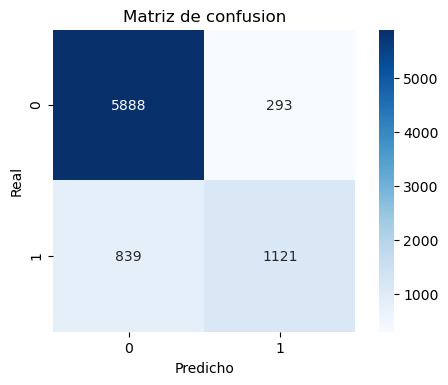

In [23]:
graficar_matriz_confusion(y_exp_holdout, y_pred)

Podemos ver que hay un ligero aumento en los valores de precision y recall para las instancias que tienen altos ingresos, lo que se ve en la matriz ya que se predicen mejor las instancias con alto valor adquisitivo.

En este caso, se mantiene la tendencia a predecir una clase sobre otra (instancias de bajos ingresos).

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con el random forest con el dataset expandido sobre el dataset de predicciones nuevo, y la escribimos al archivo 'RandomForest.csv'

In [24]:
from funciones_auxiliares import traer_df_predicciones
from preprocessing import preparar_df_predicciones
from funciones_auxiliares import escribir_predicciones

In [25]:
df_predicciones = traer_df_predicciones()
ids, df_predicciones = preparar_df_predicciones(df_predicciones)
df_predicciones = aplicar_one_hot_encoding(df_predicciones)
df_predicciones = expandir_dataset(df_predicciones)

In [26]:
predicciones = random_forest_expandido.predict(df_predicciones)
escribir_predicciones(ids, predicciones, "RandomForest")